# Build an autonomous multi-agents workflow to write picture book
## Part 2

- Workflow_2 - write story sections in paraller
- In this step, we will create two agents "cartoonist" and "editor", to write story chapters.
- The cartoonist create an initial draft for each chapter according to the outline created by last step, then editor will review the draft, and provide suggestions for cartoonist to revise the chatper
- 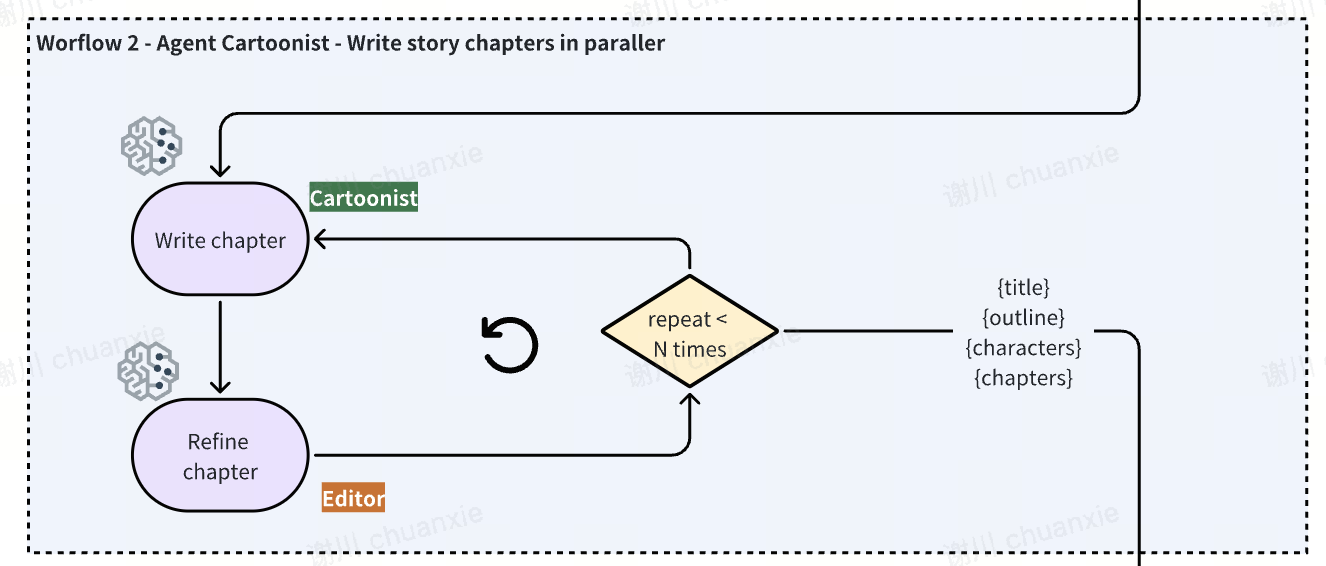 

## 2. Some Utils functions

### 2.1 Structrued Output parser
- In our case, we need to parse the LLM output to a pydantic object, so will define Structrued Output parser

In [3]:
import os
import json
import re
from langchain_core.output_parsers.base import BaseOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from json import JSONDecodeError


def dict_to_obj(json_str:dict, target:object):
    return target.parse_obj(json_str)

class CustJsonOuputParser(BaseOutputParser[str]): 
    verbose :bool = Field( default=True)

    def parse(self, text: str) -> str:
        if self.verbose:
            print(text)
        pattern = r"<answer>(.*?)</answer>"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = match.group(1)
        else:
            return {}    
        new_dict = json.loads(text.replace('\n','  '))
        
        return new_dict

    @property
    def _type(self) -> str:
        return "cust_output_parser"vcccf vv  

class TextOuputParser(BaseOutputParser[str]): 
    verbose :bool = Field( default=True)

    def parse(self, text: str) -> str:
        if self.verbose:
            print(text)
        pattern = r"<answer>(.*?)</answer>"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = match.group(1)
            return text.strip()
        else:
            return ''

    @property
    def _type(self) -> str:
        return "TextOuputParser"

- prompt facilitate to json output

In [4]:
fc_desc = """
You will ALWAYS follow the below guidelines when you are answering a question:
<guidelines>
- Think through the user's question, extract all data from the question and the previous conversations before creating a plan.
- Your response must be follow the pydantic schema as:
<schema>
{schema}
</shema>
- output your answer in json format, enclosed in tag <answer>, so that the user can use pydantic basemodel.parse_obj() to parse the json string into an object which defined as:
 <schema>
 {schema}
 </shema>
- Avoid quotation mark within a quotation mark, if encountering a quotation mark within a quotation mark, it needs to be single quotation mark instead
</guidelines>
"""

### 2.2 LLM models

In [60]:
from langchain_aws import ChatBedrock

from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm_sonnet = ChatBedrock(model_id="anthropic.claude-3-sonnet-20240229-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  callbacks=[StreamingStdOutCallbackHandler()]
                )

llm_llama31 = ChatBedrock(model_id="meta.llama3-1-405b-instruct-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  region_name='us-west-2',
                  # callbacks=[StreamingStdOutCallbackHandler()]
                )
llm = llm_sonnet

In [61]:
from langchain_core.pydantic_v1 import ValidationError

async def retry_call(chain,args: Dict[str,Any],times:int=5):
    try:
        content = await chain.ainvoke(args)
        return content
    except JSONDecodeError as e:
        if times:
            print(f'JSONDecodeError, retry again [{times}]')
            return await retry_call(chain,args,times=times-1)
        else:
            raise(JSONDecodeError(msg='JSONDecodeError'))
    except ValidationError as e:
        return "end"

### 2.3 Message format function

In [62]:
def convert_message_name(message:BaseMessage):
    if isinstance(message, AIMessage) and message.name:
        return AIMessage(content=f"{message.name} : {message.content}")
    elif isinstance(message, HumanMessage) and message.name:
        return HumanMessage(content=f"{message.name} : {message.content}")
    else:
        return message

##merge the continouse roles, and change sequences 
def reconstruct_to_claude_messages(messages):
    rec_messages = []
    for message in messages:
        message = convert_message_name(message)
        if rec_messages:
            if isinstance(rec_messages[0], AIMessage):
                rec_messages[0] = HumanMessage(content=rec_messages[0].content)
            last_msg = rec_messages[-1]
            last_role = 'assistant' if isinstance(last_msg,AIMessage) else 'user'
            current_role = 'assistant' if isinstance(message,AIMessage) else 'user'
            if last_role == current_role:
                last_msg_content = last_msg.content[-1]['text'] if isinstance(last_msg.content,list) else last_msg.content
                current_msg_content = message.content[-1]['text'] if isinstance(message.content, list) else message.content
                new_content = last_msg_content +"\n\n" + current_msg_content
                rec_messages[-1] = HumanMessage(content=new_content) if last_role == 'user' else AIMessage(content=new_content)
            else:
                rec_messages.append(message)
        else:
            rec_messages.append(message)
    return rec_messages

def swap_roles(messages, name: str):
    converted = []
    for message in messages:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return  converted

## 3 Agent Roles settings

- In this step, we will create two agents "cartoonist" and "editor", to write story chapters.
- The cartoonist create an initial draft for each chapter according to the outline created by last step, then editor will review the draft, and provide suggestions for cartoonist to revise the chatper

In [63]:
#set background information
company_setting = """You are woking in a cartoon studio, the best and creative cartoon studio in the world.\n"""

In [64]:
role_config = {
"cartoonist":  
      company_setting+"""You are a cartoonist.
Your task is to write an outline for a comics book about a user-provided topic. Be comprehensive and specific. And keep the outline as long as possible.
You can refine your story if there is suggestion provided by other roles in your studio 
      """,
    

"editor": 
      company_setting+"""You are a comics book editor, you can proofread and provide suggestions on improving the content of Plot design of the book.
Here is outline of a comics book: 
<outline>
{outline}
</outline>
You are now required to proofread and provide suggestions on specific chapter based on the outline, with the following aspects:
<aspects>
  1. it should consider the context of other chapters in the outline to continue writing your specific chapter
  2. it should consider contradictory plots with other chapter, for example a character who has gone forever in other chapter appearing again in the chapter you are writing
  3. it should consider topics such as pornography, racial discrimination, and toxic content
  4. it should be compelling and attract young people
  4. Any other suggestions which you think can improve the content
</aspects>
"""
}

- structured output prompt

In [65]:
fc_desc = """
You will ALWAYS follow the below guidelines when you are answering a question:
<guidelines>
- Think through the user's question, extract all data from the question and the previous conversations before creating a plan.
- Your response must be follow the pydantic schema as:
<schema>
{schema}
</shema>
- output your answer in json format, enclosed in tag <answer>, so that the user can use pydantic basemodel.parse_obj() to parse the json string into an object which defined as:
 <schema>
 {schema}
 </shema>
- Avoid quotation mark within a quotation mark, if encountering a quotation mark within a quotation mark, it needs to be single quotation mark instead
</guidelines>
"""

## 4.Create Prompts template and Chains

### 4.1 Outline class to format the LLM output

In [66]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

class Chapter(BaseModel):
    chapter_title: str = Field(..., description="Title of the chapter")
    description: str = Field(..., description="Summary description of the chapter")

    @property
    def as_str(self) -> str:
        return f"## {self.chapter_title}\n\n{self.description}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., description="Title of the comics book")
    chapters: List[Chapter] = Field(
        default_factory=list,
        min_items=8,
        # max_items=20,
        description="Titles and descriptions for each chapter of the comics book.",
    )

    @property
    def as_str(self) -> str:
        chapter = "\n\n".join(chapter.as_str for chapter in self.chapters)
        return f"# {self.page_title}\n\n{chapter}".strip()


### 4.2 Character class to format the LLM output
- Create a Character class to format the LLM output
- Characters consist of a main character and serveral supporting characters
- each character has own persona

In [67]:
class Persona(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the character.",
    )
    name: str = Field(
        description="only first name of character, need to match with '^[a-zA-Z0-9_-]{1,64}$'",
    )
    role: str = Field(
        description="Role of the character in the story.",
    )
    background: str = Field(
        description="background of the person in the story.",
    )
    description: str = Field(
        description="description of the character’s personality, hobbies, etc.",
    )
    figure: str = Field(
        description="figure representing such as a boy,a girl,a man, a women, a young woman,an old man or etc",
    )
    appearance: str = Field(
        description="appearance, attire of the character in the story.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nBackground: {self.background}\nDescription: {self.description}\nFigure:{self.figure}\nAppearance: {self.appearance}\n"
    
class Character(BaseModel):
    main_character: Persona = Field(
        description="the main character in the story.",
    )
    
    supporting_character: List[Persona] = Field(
        description="Comprehensive list of supporting characters in the story.",
        min_items=1,
        max_items=3,
    )
    @property
    def as_str(self) -> str:
        return "\n".join([e.persona for e in self.supporting_character])+'\n'+self.main_character.persona

### 4.3 DetailChapter class to format the LLM output
- each chapter consist of several paragrahs

In [68]:


class Paragragh(BaseModel):
    content: str = Field(..., description="Content of the Paragrah")

class DetailChapter(BaseModel):
    chapter_title: str = Field(..., description="Title of the chapter")
    paragraphs: List[Paragragh] = Field(..., description="List of paragraghs of the chapter")
    
    @property
    def as_str(self) -> str:
        chapter_content = "\n".join([p.content for p in self.paragraphs])
        return f"## {self.chapter_title}\n\n{chapter_content}".strip()
    
class EditorSuggestion(BaseModel):
    suggestions: List[str] = Field(
      description="suggestion list",
      max_items=10,
    )
    @property
    def as_str(self) -> str:
        return "\n".join([f"{i+1}.{e}" for i,e in enumerate(self.suggestions)])



### 4.3 Prompt template for write chapter and review

In [69]:
write_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["cartoonist"]  + 
         """Here is the outline of the story: 
      <outline>
      {outline}
      </outline>
      Here is the characters of the story:
      <characters>
      {characters}
      </characters>
      You are now required to write stories for specific chapter based on the outline and characters, with the following requirements:
      <requirements>
        1. You need to consider the context of other chapters in the outline to continue writing your specific chapter
        2. You can only use the characters to write the story, don't create any other characters beyond the provided characters.
        3. Avoid contradictory plots with other chapter, for example a character who has gone forever in other chapter appearing again in the chapter you are writing
        4. Avoid topics such as pornography, racial discrimination, and toxic content
      </requirements>""" + fc_desc
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ]
)

In [70]:
review_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["editor"],
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ])

## 5 Build workflow graph

### 5.1 Create LangGraph state

In [73]:
from langgraph.graph import StateGraph, END
import operator
from typing import Annotated, Sequence,Dict,Optional,Any,TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    env_var: Optional[Annotated[Dict[str, Any], operator.ior]]


### 5.2 define node functions

In [74]:

async def write_chapter(state: AgentState):
    messages = state["messages"]
    name = 'cartoonist'
    messages = swap_roles(messages,name)
    # print(messages)
    env_var = state['env_var']
    outline = env_var['outline']
    characters = env_var['characters']
    assert not outline == None
    messages = reconstruct_to_claude_messages(messages)
    assert not outline == None
    gen_chapter_chain = write_chapter_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)
    chapter_obj= await retry_call(gen_chapter_chain,{"outline":outline.json(),"messages":messages,"characters":characters.as_str,"schema":DetailChapter.schema_json()})
    
    
    ## sometimes the agent would end the converastion, so it would not follow the structured output. we should end converastion then
    if isinstance(chapter_obj,DetailChapter):
        formatted_message = AIMessage(name=name, content=chapter_obj.json())
        return {"messages":[formatted_message],"env_var":{**env_var,"chapter":chapter_obj}}
    else:
        return {"messages":[AIMessage(name=name, content="Let's end the coversation")],"env_var":{**env_var}}
    

In [75]:
async def refine_chapter(state: AgentState):
    messages = state["messages"]
    name = "editor"
    messages = swap_roles(messages,name)
    # print(messages)
    env_var = state['env_var']
    outline = env_var['outline']
    assert not outline == None
    messages = reconstruct_to_claude_messages(messages)
    refine_chapter_chain = refine_chapter_prompt | llm | StrOutputParser()
    # suggestion = await refine_chapter_chain.ainvoke({"outline":outline,"messages":messages})
    suggestion = await retry_call(refine_chapter_chain,{"outline":outline.json(),"messages":messages})
    formatted_message = AIMessage(name=name, content=suggestion)
    return {"messages":[formatted_message],"env_var":{**env_var}}
    

In [76]:
MAX_TURNS = 2
def should_repeat_write(state: AgentState):
    messages = state['messages']
    last_msg = messages[-1].content
    # print(messages)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage)]
    )
    print(f'num_responses:{num_responses}')
    if num_responses > MAX_TURNS or last_msg.startswith("Let's end the coversation"):
        return 'end'
    else:
        return 'refine_chapter'

In [77]:
write_graph = StateGraph(AgentState)

write_graph.add_node("write_chapter",write_chapter)
write_graph.add_node("refine_chapter",refine_chapter)
write_graph.set_entry_point("write_chapter")

write_graph.add_edge("refine_chapter","write_chapter")
write_graph.add_conditional_edges("write_chapter",
                                  should_repeat_write,
                                  {
                                      "end":END,
                                      "refine_chapter":"refine_chapter"
                                  })
write_workflow = write_graph.compile()

#### let's test, write a single chapter
- we use the outline and characters created in last challenge

In [78]:
# read the json file and parse to object
with open('outline.json','r') as f:
    outline_json = json.load(f)
outline = Outline.parse_obj(outline_json)

with open('characters.json','r') as f:
    characters_json = json.load(f)
characters = Character.parse_obj(characters_json)

In [79]:
steps = []
init_state = {
    "env_var":{"outline":outline,"characters":characters},
    "messages":[HumanMessage(content=f"Here is the origin content: {outline.chapters[0].json()}",name='editor')]
}
async for event in write_workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Okay, let me write the story for the chapter "The Mountain Village" based on the given outline and characters, following the requirements and guidelines:

<answer>
{
  "chapter_title": "The Mountain Village",
  "paragraphs": [
    {
      "content": "Nestled amidst the towering peaks and lush evergreen forests, a small mountain village stood as a haven of tranquility. Here, the villagers lived a simple yet contented life, their days filled with the rhythms of nature and the bonds of community. Among them were two inseparable friends, Ari and Mira, whose lives were about to take an extraordinary turn."
    },
    {
      "content": "Ari, a young boy with a boundless imagination and an insatiable curiosity, spent his days exploring the winding trails and hidden glades that surrounded the village. His eyes sparkled with wonder as he observed the intricate patterns of a spider's web, the delicate petals of a wildflower, or the graceful dance of a butterfly in the warm summer breeze. While 